# Andrew Ng's Machine Learning MOOC: Week 5: Neural Networks - Part II

# Programming Exercise 4

## 0. Introduction
This notebook contains my solutions to the programming exercise for week 5 of Andrew Ng's famous Machine Learning MOOC on Coursera (https://www.coursera.org/learn/machine-learning). 

In this exercise, we are asked to implement the back-propogation algorithm to "train" a relatively simple neural network to correctly classify a set of images represeting hand-written digits.

Our network will consist of:
- 400 input layers (to match 400 *features* in the input data)
- 25 hidden layers
- 10 output layers (to match 10 possible classes the inputs could belong to)

We implemented the feed-forward part of the neural network last week (see the notebook for Exercise 3 / week 4).

Now, the course requires submission of programming exercises in either the MATLAB or OCTAVE programming language.

However since:
* I already code in Python for various web development and data science projects, and
* Python is the pre-eminent language currently used in data science and machine learning (and MATLAB and OCTAVE don't seem to be used anywhere near as much)

I decided it would be more valuable to me to use Python to complete the programming exercises.

I was therefore very pleased to find the following source, which has kindly written a set of python scripts to allow one to create Python implementations of the programming exercises for the course, and still submit them for scoring by the MOOC:
https://github.com/dibgerge/ml-coursera-python-assignments

**Thanks very much <i>dibgerge!</i>**


In addition to the course's own lecture materials, I also used a number of other sources to help me solve the programming exercises. These include:

### Other courses I've completed:
* Harvard's Using Python for Research on edX: https://www.edx.org/course/using-python-for-research
* UC San Diego's Python for Data Science, also on edX: https://www.edx.org/course/python-for-data-science-2
* MIT's Introduction to Computational Thinking and Data Science I and II, also on edX: https://www.edx.org/course/introduction-to-computational-thinking-and-data-4
* Imperial College London's Mathematics for Machine Learning I-III on Coursera: https://www.coursera.org/specializations/mathematics-machine-learning

### Books:
* Python Machine Learning by Sebastian Raschka and Vahid Mirjalili: https://sebastianraschka.com/books.html


### Blogs and websites
I found this blog a very useful reference:
* https://www.johnwittenauer.net/machine-learning-exercises-in-python-part-5/

And of course, there's always StackOverflow!

One thing that struck me, looking at all of these different resources, is how many different ways there are to implement basically the same code in python, even using numpy and pandas dataframes! And that's before we think about object-oriented implementations, or using libraries such as scikitlearn.

OK, now that the introduction is complete, let's get started with some imports.
You can find instructions on how to install required libraries in the README file in *dibgerge*'s  [github repository](https://github.com/dibgerge/ml-coursera-python-assignments).

In [8]:
# used for manipulating directory paths
import os

# system-specific parameters and functions
import sys

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# will be used to separate our data into "training" and "testing" sub-sets
from sklearn.model_selection import train_test_split

# chart plotting library
import matplotlib.pyplot as plt

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# define the submission/grader object for this exercise
grader = utils.Grader()

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## 1. Functional Implementation of the Neural Network

Last week, in exercise 3, we implemented feedforward propagation for neural networks and used it to predict handwritten digits with weights provided by the course.

In this exercise, we will implement the backpropagation algorithm to learn the parameters for the neural network.

We start the exercise by first loading the dataset. 

In [9]:
#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex4data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

# Number of training examples
m = y.size

### 1.1 Visualizing the data

There are 5000 training examples in `ex4data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each
of these training examples becomes a single row in our data matrix $X$. This gives us a 5000 by 400 matrix $X$ where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix} - \left(x^{(1)} \right)^T - \\
- \left(x^{(2)} \right)^T - \\
\vdots \\
- \left(x^{(m)} \right)^T - \\
\end{bmatrix}
$$

The second part of the training set is a 5000-dimensional vector `y` that contains labels for the training set. 

The following cell randomly selects 100 images from the `X` dataset and plots them, using a funcgtion `displayData()` provided by the course.

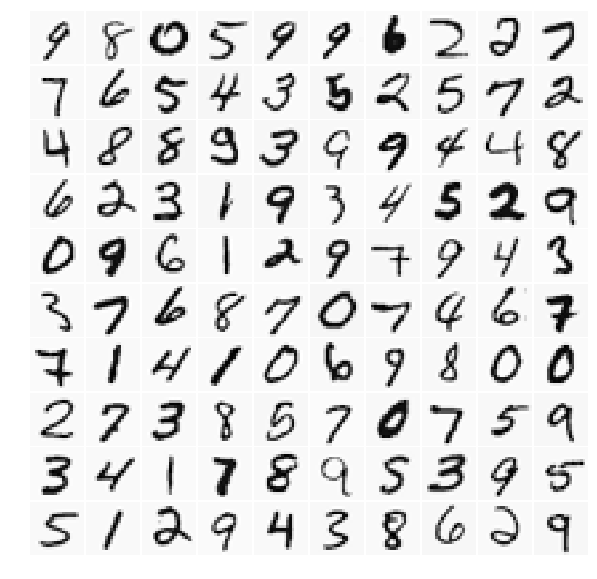

In [10]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

### 1.2 Model representation

Our neural network is shown in the following figure.

![](Figures/neural_network.png)

It has 3 layers - an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values
of digit images. Since the images are of size $20 \times 20$, this gives us 400 input layer units (not counting the extra bias unit which always outputs +1). The training data was loaded into the variables `X` and `y` above.

The course provides us with a pre-trained initial set of network parameters ($\Theta^{(1)}, \Theta^{(2)}$). These are stored in `ex4weights.mat` and will be loaded in the next cell of this notebook into `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [11]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Load the weights into variables Theta1 and Theta2
weights = loadmat(os.path.join('Data', 'ex4weights.mat'))

# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

# Unroll parameters 
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

### 1.3 Feedforward or forward-propogation

Overall, our task is to write a function or functions that:

- implements feed-forward propogation and calculates (and returns) the cost $J$ of the neural network
- implements back propogation, and calculates (and returns) the gradients of the cost $\Delta(J)$

Now we've loaded our data, let's start by implementing feedforward propagation for the neural network.

To do this, we will write/complete the function `predict`, which will return the neural network’s prediction for a given set of inputs. Specifically, we need to implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example $i$ and returns the associated predictions. Similar to the one-vs-all classification strategy, the prediction from the neural network will be the label that has the largest output $\left( h_\theta(x) \right)_k$.

Now, remember from lat week, there are some implementation choices to make - and I'm going to take a slightly different approach from the course's representational choices.  First of all, let's look at the shapes of our different data:

In [12]:
X.shape, y.shape, Theta1.shape, Theta2.shape

((5000, 400), (5000,), (25, 401), (10, 26))

So, what are we seeing?
- Well, $X$ is a [5000 x 400] matrix, representing 5,000 examples, each with 400 "features" - i.e. 5,000 different images of hand-written numbers, each with a value representing each of 400 pixels that make up the image. Every unit in the input represents a single pixel.
- $y$ is a [5000-row] vector, representing the number that each image represents (from 0 to 9) - we can think of this as the "target output".
- $\Theta^1$ is a [25 x 401] matrix, with each row representing a unit in our hidden layer, and each column representing the weights for the connection between each of the 400 pixels in our input layer, and the 25 units in the hidden layer.
-  $\Theta^2$ is a [10 x 26] matrix, with each row representing a unit in our output layer, and each column representing the weights for the connection between each of the 25 hidden layer units and the 10 units in the output layer.

***Wait, what?***

If $\Theta^1$ represents the weights of the connections between 400 input units, and 25 hidden layer units, how come its dimensions are [25 x **401**]?

And if $\Theta^2$ representes the weights of the connections between 25 hidden layer units and 10 output layer units, how come *its* dimensions are [10 X **26**]?

Well, this comes down to a - *difference of opinion*? - in how to represent neural networks.

All neural networks are built with a "bias unit" in each layer. Now, in this course, it seems we are to represent the bias unit as:
- An additional column [of 1s] in the input data [the "bias unit" always outputs 1]
- An additional column of weights between each layer - with the final column of weights acting on the bias unit.

However, other sources (e.g. Imperial's *Mathematics for Machine Learning* (course)[https://www.coursera.org/specializations/mathematics-machine-learning]) represent things differently. Imagine a really simple neural network with only two nodes. They represent the *net input* from the node in layer 0 to the node in layer 1 as:

$$a^1 = w^0.a^0 + b$$

The output (or "activity") of $a^1$ is then

$$\sigma(a^1)$$which is to say $$\sigma(w_0.a_0 + b)$$

If we add a second node to the layer0, we get

$$a^1 = \sigma(w_0.a_0^0 + b) + \sigma(w_1.a_1^0 + b)$$

Re-arranging, we get:

$$a^1 = \sigma(w_0.a_0^0 + w_1.a_1^0+ b)$$

Which is to say:

$$a^1 = \sigma(W^1.a^0 + b^1)$$

where:
- $W^1$ is the matrix of weights between units in layer 0 to units layer 1
- $a^0$ is the vector of inputs coming out of layer 0
- $b^1$ is the vector of biases for the inputs into each unit in layer 1 [**Note** the biases are the same for each unit in layer 1]

Below, when I create an object-oriented implementation of this neural network, following the approach set out in *Raschka and Mirjalili*, we'll see that they follow this approach, too.

Personally, I like this approach to representing neural networks, because:
- The dimensions of each layer matches the dimensions of the layer preceeding it (e.g. our inputs are 400-columns wide; so I'd expect our weights to also be 400-columns wide...not 401). This means we don't need to add a column of 1s to our data before using it.
- We can pull out the biases and weights into separate matrices/vectors and adjust them separately.

Looking back at the way our data is represented, we can see that the course has added an additional column of weights to both sets of connections (i.e. between the input layer and the hidden layer; and between the hidden layer and the output layer). The approach suggested by the course is for us to add a column of 1s to our input data to represent the (output of the) bias units.

Instead, I'd like to try representing the bias units as a set of vectors, which means that instead of adding a column of 1s to the input data, I'm going to *strip out* a column from each of the weights matrices (i.e. $\Theta$ 1 and 2) and having them represent the biases.

Based on last week, I'm going to assume that the bias vectors are encoded in column[0] of $\Theta$ 1 and 2

I'm going to break up the exercise into a few different functions that we can call within each other - otherwise we end up with a very long and difficult to interpret load of code!

If I'm honest with everyone, I'm also going to lean heavily on the object-oriented implementation, from *Raschka and Mirjalili*, which I reproduce in section 2 below.

First of all, we're going to need to "one-hot" encode our labels. One-hot encoding turns a class label `n` (out of `k` classes) into a vector of length `k` where index n is "hot" (represented by the value `1`) while the rest are zero. Scikit-learn has a built in utility we can use for this; but it's also easy to write our own function:

In [13]:
def onehot(y, n_classes):
    """
    Encodes labels into one-hot representation

    Parameters
    ----------
    y: array, shape = n_samples
        Target values

    Returns
    -------
    onehot: array, shape = [n_samples, n_labels]
    """
    onehot = np.zeros((n_classes, y.shape[0]))
    for idx, val in enumerate(y.astype(int)):
        onehot[val, idx] = 1
    return onehot.T

Now we need to define our forward-propogation algorithm. We're going to take advantage of the supplied `utils.sigmoid()` function - but we could easily define this for ourselves - see last week's exercise for details.

**Note** that in this function we explicitly separate the weights from the bias units - so we're going to need to be very careful in pulling these out - and then putting them back together again for the final outputs.

In [14]:
def forward_propogate(X, w_hidden, b_hidden, w_output, b_output):
    """
    Computes forward-propogation step
    
    Parameters
    ----------
    X: array-like, shape = [n_samples x n_features]
        Input data
        
    w_hidden: matrix, shape = [n_features x n_hidden]
        vector of weights of connections between
        the input data layer and the hidden layer
        
    b_hidden: vector, shape = [n_hidden]
        vector of weights between bias unit in input layer
        and each unit in hidden layer
        
    w_output: matrix, shape = [n_hidden x n_classlabels]
        vector of weights of connections between
        the hidden layer and output layer
        
    b_output: vector, shape = [n_output]
        vector of weights between bias unit in hidden layer
        and each unit in output layer
        
    Returns
    -------
    z_hidden: array, shape = [n_samples x n_hidden]
        net input to hidden layer
    
    a_hidden: array, shape = [n_samples x n_hidden]
        activation of hidden layer
    
    z_output: array, shape = [n_samples, n_classlables]
        net input to output layer
    
    a_output: array, shape = []
        activation of output layer
    """
    # step 1: calculate net input to hidden layer
    # [n_samples, n_features] dot [n_features, n_hidden]
    # --> [n_samples, n_hidden]
    z_hidden = np.dot(X, w_hidden.T) + b_hidden

    # step 2: calculate activation of hidden layer
    a_hidden = utils.sigmoid(z_hidden)

    # step 3: calculate net input to output layer
    # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
    # --> [n_samples, n_classlables]
    z_output = np.dot(a_hidden, w_output.T) + b_output

    #step 4: calculate activation of output layer
    a_output = utils.sigmoid(z_output)

    return z_hidden, a_hidden, z_output, a_output

### 1.4 Cost Function

Now we define a function, `nnCostFunction`, that will return the cost $J(\theta$) for all the nodes in our neural network (later we will also add the calculation of the gradients of all the nodes in the network with respect to the cost, to this function).

I've gone straight to implementing the regularized version of this function. The function's default parameter for `lambda_`, however, is 0; so unless we specify something different, the function will return an unregularized result (because we'll multiply the regularization term by 0).

The cost function for neural networks with regularization is given by:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$

Note also that the input parameter `nn_params` is an "unrolled" vector of all of the weights in Theta1 and Theta2, *including the bias terms*. The first step of this function is therefore to separate these weights into Theta1 and Theta2 and re-shape these into the appropriately-sized matrices. In particular, given the implementaton I've followed, we also need to separate out the bias terms.

### 1.5 Back-Propogation

Now we implement the backpropagation algorithm to compute the gradient for the neural network cost function. We will include the code for this within our function  `nnCostFunction`, and return the gradient in the variable `grad`. Once we've computed the gradient, we can train the neural network by minimizing the cost function $J(\theta)$ using an advanced optimizer such as `scipy`'s `optimize.minimize`.

![](Figures/ex4-backpropagation.png)

The intuition behind the backpropagation algorithm is as follows. Given a training example $(x^{(t)}, y^{(t)})$, we will first run a “forward pass” to compute all the activations throughout the network, including the output value of the hypothesis $h_\theta(x)$. Then, for each node $j$ in layer $l$, we would like to compute an “error term” $\delta_j^{(l)}$ that measures how much that node was “responsible” for any errors in our output.

For an output node, we can directly measure the difference between the network’s activation and the true target value, and use that to define $\delta_j^{(3)}$ (since layer 3 is the output layer). For the hidden units, we will compute $\delta_j^{(l)}$ based on a weighted average of the error terms of the nodes in layer $(l+1)$.

In detail, here is the backpropagation algorithm (also depicted in the figure above).

1.Set the input layer’s values $(a^{(1)})$ to the $t^{th }$training example $x^{(t)}$. Perform a feedforward pass, computing the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3.



2.For each output unit $k$ in layer 3 (the output layer), set 
$$\delta_k^{(3)} = \left(a_k^{(3)} - y_k \right)$$
where $y_k \in \{0, 1\}$ indicates whether the current training example belongs to class $k$ $(y_k = 1)$, or if it belongs to a different class $(y_k = 0)$.



3.For the hidden layer $l = 2$, set 
$$ \delta^{(2)} = \left( \Theta^{(2)} \right)^T \delta^{(3)} * g'\left(z^{(2)} \right)$$
(Note that the symbol $*$ performs element wise multiplication in `numpy`.)

Here, $$ g'(z^{(2)}) $$

is simply the derivative of the activation function, $z$ of layer 2 (i.e. the output layer).

Now, the activation function is the sigmoid function:

$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$

...and the derivative, or gradient of this function is:

$$ g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right) $$



4.Accumulate the gradients:
$$ \Delta^{(l)} = \Delta^{(l)} + \delta^{(l+1)} (a^{(l)})^{(T)} $$



5.Obtain the gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$:
$$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)}$$


6.Regularize the gradients **with the *exception* of the bias terms**, as defined below:

$$ \begin{align}
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} + \frac{\lambda}{m} \Theta_{ij}^{(l)}
\end{align}
$$

### 1.5.1 Vectorized Implementation

The explanation given above represents us calculating the gradients separately for each node in each layer. This is a useful way to explain what the algorithm is doing. And we can, in fact, complete the algorithm in this manner, by using a `for-loop` construction and looping over each node in turn - in fact, this is what the course suggests we should do.

This, however, is **definitely not** the optimal way of doing things! A much better way of computing the gradients is to remember that each layer is a *matrix* of weights, and we can actually calculate the gradients much more quickly using linear algebra (i.e., multiplying the matrices together). Mathematically, this is represented as:


- accumulate the gradients:

$$ \Delta^{(h)} = \Delta^{(h)} + (A^{(out)})^{T}\delta^{(h)}  $$


$$ \Delta^{(out)} = \Delta^{(out)} + (A^{(h)})^{T}\delta^{(out)}  $$


- add the regularization term:

$$ \Delta^{(l)} := \Delta^{(l)} + \lambda^{(l)}  $$
(*except for the bias term, which is not regularized*)


Note: if the maths here is a bit tricky, I'd highly recommend the Imperial College *Mathematics for Machine Learning* courses - especially the first two on linear algebra and calculus. Links in the introduction.

Not only is it much less expensive computationally to compute the gradients this way; it's also much simpler to code, as we can write this in a few lines, rather than having to run through error-prone `for-loops`.

### 1.5.2 Final steps to implementation

Because of the way the course's approach (and grader) is structured, we need to return the gradients as a single vector *including the bias terms* - so that we can provide input to the grader for this exercise in the format it expects; and to be able to use `optimize.minimize`. That means that the final step in calculating the gradients of all the weights in the neural network will be to "unroll" them all back together into a single vector *including the bias terms*.

Final note - given the way this exercise has been structured by the course, *we don't actually write the code to update the weights*. This is because we use the `optimize.minimize()` method from the `scipy` library to run a through a number (e.g. 100+) iterations of our code, and this updates the nn_params accordingly, based on the gradients we calculate. If you want to see how this could be done in our own code, look at the object-oriented version of the code that I've put at the bottom of this notebook in section 3.

Before we start, however, there's something else we need to do - which is to randomize our initial "guesses" for the weights.

### 1.5.3 Random Initialization

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$.

<div class="alert alert-box alert-warning">
One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network. A good choice of $\epsilon_{init}$ is $\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$ where $L_{in} = s_l$ and $L_{out} = s_{l+1}$ are the number of units in the layers adjacent to $\Theta^{l}$.
</div>

Our job is to complete the function `randInitializeWeights` to initialize the weights for $\Theta$.

```python
# Randomly initialize the weights to small values
W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
```

We are told to use $\epsilon_{init} = 0.12$ - note that we set this as the default value in our function. This range of values ensures that the parameters are kept small and makes the learning more efficient.

In [15]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    """
    Randomly initialize the weights of a layer in a neural network.
    
    Parameters
    ----------
    L_in : int
        Number of incomming connections.
    
    L_out : int
        Number of outgoing connections. 
    
    epsilon_init : float, optional
        Range of values which the weight can take from a uniform 
        distribution.
    
    Returns
    -------
    W : array_like
        The weight initialiatized to random values.  Note that W should
        be set to a matrix of size(L_out, 1 + L_in) as
        the first column of W represents the weights for the "bias" terms.
    """

    # initialize a matrix to hold the weights 
    W = np.zeros((L_out, 1 + L_in))

    # fill the matrix with randomly initialized numbers
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init

    ### CHECK DIMENSIONS ###
    # print("W's shape is {}".format(W.shape))

    return W

We initialize the weights for the 2 layers in the neural network using the `randInitializeWeights()` function we've just defined:

In [16]:
print('Initializing Neural Network Parameters ...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

Initializing Neural Network Parameters ...


### 1.5.4 Implementing the Cost Function and Back-Propogation

Now let's define `nnCostFunction()`, which will:
- run a single step of feed-forward propogation and calculate the predicted outputs of the network
- calculate the cost function (based on the difference between the predicted outputs and the actual data)
- run back-propogation to calculate the gradient, or derivative, of the weights of each connection between the nodes in the network
- return the cost and the gradients (with the gradients represented as a single "unrolled" vector *including the bias terms*

In [17]:
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_= 0.0):
    """
    Implements the neural network cost function and gradient for a two layer neural 
    network which performs classification. 
    
    Parameters
    ----------
    nn_params : array_like
        The parameters for the neural network which are "unrolled" into 
        a vector. This needs to be converted back into the weight matrices Theta1
        and Theta2.
    
    input_layer_size : int
        Number of features for the input layer. 
    
    hidden_layer_size : int
        Number of hidden units in the second layer.
    
    num_labels : int
        Total number of labels, or equivalently number of units in output layer. 
    
    X : array_like
        Input dataset. A matrix of shape (m x input_layer_size).
    
    y : array_like
        Dataset labels. A vector of shape (m,).
    
    lambda_ : float, optional
        Regularization parameter.
 
    Returns
    -------
    J : float
        The computed value for the cost function at the current weight values.
    
    grad : array_like
        An "unrolled" vector of the partial derivatives of the concatenatation of
        neural network weights Theta1 and Theta2.
        
    NOTES
    ----
    It's very useful to include a number of `print` statements to double-check the
    dimensions of the various matrices being created. These aren't included in the code
    below, but could easily be added, e.g.:
        
        print("input layer size is {}".format(input_layer_size))
        
    """
    ##############
    ### SET UP ###
    ##############
    
    # set up variable to hold number of samples
    m = X.shape[0]
    
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))
    
    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))
    
    # separate bias vectors from Theta1 and Theta2
    w_hidden, b_hidden = Theta1[:, 1:], Theta1[:, 0:1]
    w_output, b_output = Theta2[:, 1:], Theta2[:, 0:1] 
    
    # turn b_hidden and b_output into vectors (rather than n x 1 matrices)
    b_hidden = b_hidden.ravel() 
    b_output = b_output.ravel()
    
    # instantiate one-hot encoded version of y
    y_onehot = onehot(y, num_labels)
    
    ##########################
    ### CALCULATE THE COST ###
    ##########################
    
    # run forward propogation
    z_hidden, a_hidden, z_output, a_output = forward_propogate(X, w_hidden, b_hidden, w_output, b_output)
    
    # compute cost - including regularization
    term1 = -y_onehot * (np.log(a_output))
    term2 = (1. - y_onehot) * np.log(1. - a_output)
    L2_term = lambda_ * (np.sum(w_hidden**2)
                         + np.sum(w_output**2))
    J = (np.sum((term1 - term2)/m) + (L2_term/(2*m)))
    
    ########################
    ### BACK PROPOGATION ###
    ########################
    
    # intstantiate matrices to hold the gradients at each stage
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)

    # 1. calculate error term for output layer
        # [n_samples, n_classlabels]
    sigma_output = a_output - y_onehot
    
    
    # 2. calculate error term for hidden layer
    # 2.1 calculate derivative of sigmoid activation function hidden layer
        # [n_samples, n_hidden]
    sigmoid_derivative_hidden = a_hidden * (1. - a_hidden)

    # 2.2 calculate error term of hidden layer
        # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
        # --> [n_samples, n_hidden]
    sigma_hidden = (np.dot(sigma_output, w_output) * sigmoid_derivative_hidden)

    # 3. accumulate partial derivatives of each node in hidden layer 
        # [n_feature, n_samples] dot [n_samples, n_hidden]
        # --> [n_features, n_hidden]
    grad_w_hidden = np.dot(X.T, sigma_hidden)
    grad_b_hidden = np.sum(sigma_hidden, axis = 0)

    # 4. accumulate partial derivatives of each node in output layer
        # [n_hidden, n_samples] dot [n_samples, n_classlabels]
        # --> [n_hidden, n_classlabels]
    grad_w_output = np.dot(a_hidden.T, sigma_output)
    grad_b_output = np.sum(sigma_output, axis = 0)
    
    # 5. regularize accumulated partial derivatives in hidden and output layers
    delta_w_hidden = (grad_w_hidden + lambda_*w_hidden.T)/m
    delta_b_hidden = grad_b_hidden/m # NB bias term is not regularized
    # create a 10 x 1 matrix version of delta_b_hidden
    delta_b_hidden_matrix = np.reshape(delta_b_hidden,(delta_b_hidden.size, 1))
    
    delta_w_output = (grad_w_output + lambda_*w_output.T)/m
    delta_b_output = grad_b_output/m # NB bias term is not regularized
    # create a 10 x 1 matrix version of delta_b_output
    delta_b_output_matrix = np.reshape(delta_b_output,(delta_b_output.size, 1))
    
    # 6. combine gradients of weight and bias terms into Theta1_grad and Theta2_grad - as required by
    # the representational framework of the exercise
    # NOTE b terms are column[0] of Theta1 and Theta2
    Theta1_grad = np.concatenate([delta_b_hidden_matrix, delta_w_hidden.T], axis = 1)
    Theta2_grad = np.concatenate([delta_b_output_matrix, delta_w_output.T], axis = 1)
     
    # Combine gradients back into a single vector
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])

    return J, grad

We can test our implementation of `nnCostFunction` by calling it using the loaded set of parameters for `Theta1` and `Theta2` on two test cases.

In the first case, we set $\lambda$ to be 0 (i.e. an un-regularized cost function). We should see that the cost is about 0.287629.

In the second case, we set $\lambda$ to be 1 (i.e. a regularized cost function). We should see the cost is about 0.383770.

In [18]:
lambda_ = 0
J, grad = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lambda_)
print('Cost at parameters (loaded from ex4weights): %.6f ' % J)
print('The cost should be about                   : 0.287629.')

Cost at parameters (loaded from ex4weights): 0.287629 
The cost should be about                   : 0.287629.


In [19]:
# Weight regularization parameter (we set this to 1 here).
lambda_ = 1
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                      num_labels, X, y, lambda_)

print('Cost at parameters (loaded from ex4weights): %.6f' % J)
print('This value should be about                 : 0.383770.')

Cost at parameters (loaded from ex4weights): 0.383770
This value should be about                 : 0.383770.


### 1.6 Gradient checking 

Now we've implemented the backpropagation algorithm, we can "check the gradient" on our implementation. This will increase our confidence that our code is computing the gradients correctly.

In our neural network, we are minimizing the cost function $J(\Theta)$. To perform gradient checking on our parameters, we can imagine “unrolling” the parameters $\Theta^{(1)}$, $\Theta^{(2)}$ into a long vector $\theta$. We can then think of the cost function being $J(\Theta)$, and use the following gradient checking procedure:

Suppose you have a function $f_i(\theta)$ that purportedly computes $\frac{\partial}{\partial \theta_i} J(\theta)$; you’d like to check if $f_i$ is outputting correct derivative values.

$$
\text{Let } \theta^{(i+)} = \theta + \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix}
\quad \text{and} \quad \theta^{(i-)} = \theta - \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix}
$$

So, $\theta^{(i+)}$ is the same as $\theta$, except its $i^{th}$ element has been incremented by $\epsilon$. Similarly, $\theta^{(i−)}$ is the corresponding vector with the $i^{th}$ element decreased by $\epsilon$. You can now numerically verify $f_i(\theta)$’s correctness by checking, for each $i$, that:

$$ f_i\left( \theta \right) \approx \frac{J\left( \theta^{(i+)}\right) - J\left( \theta^{(i-)} \right)}{2\epsilon} $$

The degree to which these two values should approximate each other will depend on the details of $J$. But assuming $\epsilon = 10^{-4}$, we should usually find that the left- and right-hand sides of the above will agree to at least 4 significant digits (and often many more).

The course and/or `dibgerge` have kindly implemented the function to compute the numerical gradient for us in `computeNumericalGradient()` (within the file `utils.py`).

In the next cell we will call `checkNNGradients()` which will create a small neural network and dataset that will be used for checking the gradients we calculated. If our backpropagation implementation is correct, we should see a relative difference that is less than 1e-9.

<div class="alert alert-box alert-success">
**Practical Tip**: When performing gradient checking, it is much more efficient to use a small neural network with a relatively small number of input units and hidden units, thus having a relatively small number of parameters. Each dimension of $\theta$ requires two evaluations of the cost function and this can be expensive. In the function `checkNNGradients`, our code creates a small random model and dataset which is used with `computeNumericalGradient` for gradient checking.

After you are confident that your gradient computations are correct, you should turn off gradient checking before running your learning algorithm.
</div>

<div class="alert alert-box alert-success">
**Practical Tip:** Gradient checking works for any function where you are computing the cost and the gradient. Concretely, you can use the same `computeNumericalGradient` function to check if your gradient implementations for the other exercises are correct too (e.g., logistic regression’s cost function).
</div>

First, we'll check the gradients for an un-regularized call to `nnCostFunction()`:

In [20]:
utils.checkNNGradients(nnCostFunction)

[[ -9.27825235e-03  -9.27825236e-03]
 [ -3.04979153e-06  -3.04978914e-06]
 [ -1.75060082e-04  -1.75060082e-04]
 [ -9.62660618e-05  -9.62660620e-05]
 [  8.89911959e-03   8.89911960e-03]
 [  1.42869427e-05   1.42869443e-05]
 [  2.33146356e-04   2.33146357e-04]
 [  1.17982666e-04   1.17982666e-04]
 [ -8.36010761e-03  -8.36010762e-03]
 [ -2.59383093e-05  -2.59383100e-05]
 [ -2.87468729e-04  -2.87468729e-04]
 [ -1.37149709e-04  -1.37149706e-04]
 [  7.62813550e-03   7.62813551e-03]
 [  3.69883235e-05   3.69883234e-05]
 [  3.35320345e-04   3.35320347e-04]
 [  1.53247079e-04   1.53247082e-04]
 [ -6.74798369e-03  -6.74798370e-03]
 [ -4.68759809e-05  -4.68759769e-05]
 [ -3.76215588e-04  -3.76215587e-04]
 [ -1.66560294e-04  -1.66560294e-04]
 [  3.14544970e-01   3.14544970e-01]
 [  1.64090819e-01   1.64090819e-01]
 [  1.64567932e-01   1.64567932e-01]
 [  1.58339334e-01   1.58339334e-01]
 [  1.51127527e-01   1.51127527e-01]
 [  1.49568335e-01   1.49568335e-01]
 [  1.11056588e-01   1.11056588e-01]
 

Now we'll check the gradients calculated by a regularized call to `nnCostFunction()`

In [21]:
#  Check gradients by running checkNNGradients
lambda_ = 3
utils.checkNNGradients(nnCostFunction, lambda_)

# Also output the costFunction debugging values
debug_J, _  = nnCostFunction(nn_params, input_layer_size,
                          hidden_layer_size, num_labels, X, y, lambda_)

print('\n\nCost at (fixed) debugging parameters (w/ lambda = %f): %f ' % (lambda_, debug_J))
print('(for lambda = 3, this value should be about 0.576051)')

[[ -9.27825235e-03  -9.27825236e-03]
 [ -1.67679797e-02  -1.67679797e-02]
 [ -6.01744725e-02  -6.01744725e-02]
 [ -1.73704651e-02  -1.73704651e-02]
 [  8.89911959e-03   8.89911960e-03]
 [  3.94334829e-02   3.94334829e-02]
 [ -3.19612287e-02  -3.19612287e-02]
 [ -5.75658668e-02  -5.75658668e-02]
 [ -8.36010761e-03  -8.36010762e-03]
 [  5.93355565e-02   5.93355565e-02]
 [  2.49225535e-02   2.49225535e-02]
 [ -4.51963845e-02  -4.51963845e-02]
 [  7.62813550e-03   7.62813551e-03]
 [  2.47640974e-02   2.47640974e-02]
 [  5.97717617e-02   5.97717617e-02]
 [  9.14587966e-03   9.14587966e-03]
 [ -6.74798369e-03  -6.74798370e-03]
 [ -3.26881426e-02  -3.26881426e-02]
 [  3.86410548e-02   3.86410548e-02]
 [  5.46101547e-02   5.46101547e-02]
 [  3.14544970e-01   3.14544970e-01]
 [  1.18682669e-01   1.18682669e-01]
 [  2.03987128e-01   2.03987128e-01]
 [  1.25698067e-01   1.25698067e-01]
 [  1.76337550e-01   1.76337550e-01]
 [  1.32294136e-01   1.32294136e-01]
 [  1.11056588e-01   1.11056588e-01]
 

### 1.7 Learning parameters using `scipy.optimize.minimize`

Now we we will use `scipy`'s minimization module to learn a good set parameters.

In [26]:
#  We can change maxiter to a larger value to see how more training helps.
options= {'maxiter': 400}

#  We can also try different values of lambda
lambda_ = 1

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, X, y, lambda_)

# Now, costFunction is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

# Get the solution of the optimization
nn_params = res.x
        
# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

After the training completes, we will look at the training accuracy of our classifier by computing the percentage of examples it got correct. If our implementation is good, we should see a reported training accuracy of about 95.3% (this may vary by about 1% due to the random initialization).

It is possible to get higher training accuracies by training the neural network for more iterations. For example, try training the network with 400 iterations (e.g., set `maxiter` to 400). We can also vary the regularization parameter $\lambda$.

Neural networks are very powerful models that can form highly complex decision boundaries. Without regularization, it is possible for a neural network to “overfit” a training set so that it obtains close to 100% accuracy on the training set but does perform well on new examples that it has not seen before.

In [27]:
pred = utils.predict(Theta1, Theta2, X)
print('Training Set Accuracy: %f' % (np.mean(pred == y) * 100))

Training Set Accuracy: 99.540000


We can see that, with 100 training iterations, we get to an accuracy around 96%; and with 400, we get over 99% accuracy.

## 2. Visualizing the Hidden Layer

One way to understand what the neural network is learning is to visualize what the representations captured by the hidden units. Informally, given a particular hidden unit, one way to visualize what it computes is to find an input $x$ that will cause it to activate (that is, to have an activation value 
($a_i^{(l)}$) close to 1). For the neural network we've trained, notice that the $i^{th}$ row of $\Theta^{(1)}$ is a 400-dimensional vector that represents the parameter for the $i^{th}$ hidden unit - i.e. the weights from each input pixel to the hidden unit.

Thus, one way to visualize the “representation” captured by the hidden unit is to reshape this 400 dimensional vector into a 20 × 20 image and display it (It turns out that this is equivalent to finding the input that gives the highest activation for the hidden unit, given a “norm” constraint on the input (i.e., $||x||_2 \le 1$)). 

The next cell does this by using the `displayData` function and it will show us an image with 25 units,
each corresponding to one hidden unit in the network. In our trained network, we should find that the hidden unit layer corresponds roughly to detectors that look for strokes and other patterns in the input.

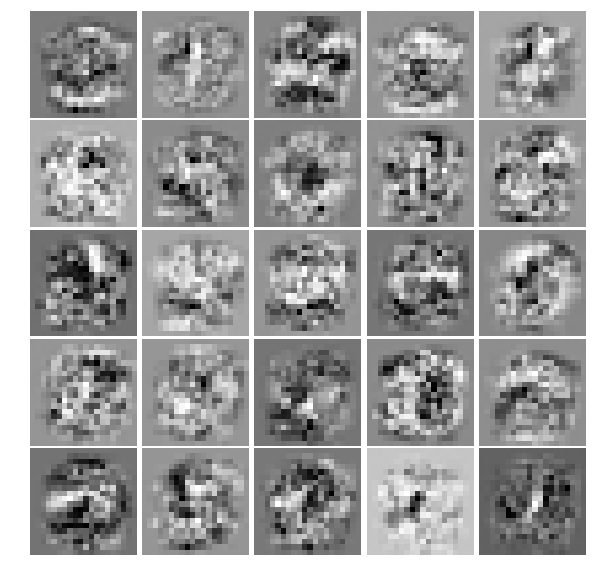

In [28]:
utils.displayData(Theta1[:, 1:])

## 3 An object oriented implementation

Here I'm going to write an object-oriented implementation (taken from Raschka and Mirjalili) and see how it works. 

In [29]:
# defines a neural net (multi-layer perceptron) classifier object
class NeuralNetMLP(object):
    """
    Feed-forward neural network / multi-layer perceptron classifier
    Comprises:
        - 1 input layer (size determined by number of features of 
                        input data)
        - 1 hidden layer (size passed as a parameter when
                        instantiating the object)
        - 1 output layer (size determined by number of classes required)

    Paramaters
    ----------
    n_hidden: int (default: 25)
        Number of hidden units
    l2: float (default: 0)
        Lambda value for L2-regularization
        l2 = 0 means no regularization (the default option)
    epochs: int (default: 100)
        Number of runs over the training set
    learning_rate: float (default: 0.001)
        Learning rate
    shuffle: bool (default: True)
        If True, shuffles training data every epoch
        to prevent circles
        Default is True
    minibatch_size: int (default: 1)
        Number of training samples per minibatch
    seed: int (default: None)
        Random seed for initializing weights and shuffling
        
    Attributes
    ----------
    eval_ : dict
        Dictionary collecting the cost, training accuracy, and 
        validation accuracy for each epoch during training    
    """
    
    def __init__(self, n_hidden = 25, l2 = 0., epochs = 100,
                 learning_rate = 0.001, shuffle = True,
                 minibatch_size = 1, seed = None):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        
    
    def _onehot(self, y, n_classes):
        """
        Encode labels into one-hot representation
        
        Parameters
        ----------
        y: array, shape = n_samples
            Target values
        
        Returns
        -------
        onehot: array, shape = [n_samples, n_labels]
        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1
        return onehot.T
        
    def _sigmoid(self, z):
        """Compute sigmoid as logistic function"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    
    def _forward(self, X):
        """Compute forward-propogation step"""
        # step 1: calculate net input to hidden layer
        # [n_samples, n_features] dot [n_features, n_hidden]
        # --> [n_samples, n_hidden]
        z_hidden = np.dot(X, self.w_hidden) + self.b_hidden
        
        # step 2: calculate activation of hidden layer
        a_hidden = self._sigmoid(z_hidden)
        
        # step 3: calculate net input to output layer
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # --> [n_samples, n_classlables]
        z_output = np.dot(a_hidden, self.w_output) + self.b_output
    
        #step 4: calculate activation of output layer
        a_output = self._sigmoid(z_output)
        
        return z_hidden, a_hidden, z_output, a_output
    
    
    def _compute_cost(self, y_enc, output):
        """
        Compute cost function
        
        Parameters
        ----------
        y_enc: array, shape = [n_samples, n_labels]
            one-hot encoded class labels
        output: array, shape = [n_samples, n_output_units]
            Activation of the output layer (from forward propogation)
            
        Returns
        -------
        cost: float
            Regularized cost (though NB default for lambda is 0,
            equivalent to no regularization)
        """
        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        L2_term = self.l2 * (np.sum(self.w_hidden**2)
                             + np.sum(self.w_output**2))
        cost = np.sum(term1 - term2) + L2_term
        return cost
    
    
    def predict(self, X):
        """
        Predict class labels
        
        Parameters
        ----------
        X: array, shape = [n_samples, n_features]
            Input layer with original features
        
        Returns
        -------
        y_predicted: array, shape = [n_samples]
            Predicted class labels for each input sample
        """
        z_hidden, a_hidden, z_output, a_output = self._forward(X)
        y_predicted = np.argmax(z_output, axis = 1)
        return y_predicted
    
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        """
        Learn weights from training data
        
        Parameters
        ----------
        X_train: array, shape = [n_samples, n_features]
            Input layer with original features
        y_train: array, shape = [n_samples]
            Target class labels
        X_valid: array, shape = [n_samples, n_features]
            Sample features for validation during training
        y_valid: array, shape = [n_samples]
            Sample labels for validation during training
            
        Returns
        -------
        self
        """
        n_output = np.unique(y_train).shape[0] # number of class labels
        n_features = X_train.shape[1] # number of features
        
        #########################
        # Weight Initialization #
        #########################
        
        # weights for input layer --> hidden layer
        self.b_hidden = np.zeros(self.n_hidden)
        self.w_hidden = self.random.normal(loc = 0.0, scale = 0.1,
                                           size = (n_features,
                                                   self.n_hidden))
        
        # weights for hidden layer --> output layer
        self.b_output = np.zeros(n_output)
        self.w_output = self.random.normal(loc = 0.0, scale = 0.1,
                                           size = (self.n_hidden, n_output))
        
        epoch_strlen = len(str(self.epochs)) # for progr. format
        self.eval_ = {"cost" : [], "training_accuracy" : [], "validation_accuracy" : []}
        
        y_train_enc = self._onehot(y_train, n_output)
        
        # iterate over training epochs
        for i in range (self.epochs):
            # iterate over minibatches
            indices = np.arange(X_train.shape[0])
            
            if self.shuffle:
                self.random.shuffle(indices)
                
            for start_idx in range(9, indices.shape[0] +\
                                   self.minibatch_size + \
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx : start_idx +\
                                    self.minibatch_size]
                
                # forward propogation
                z_hidden, a_hidden, z_output, a_output = self._forward(X_train[batch_idx])
                
                ####################
                # Back-propogation #
                ####################
                
                # [n_samples, n_classlabels]
                sigma_output = a_output - y_train_enc[batch_idx]
                
                # [n_samples, n_hidden]
                sigmoid_derivative_hidden = a_hidden * (1. - a_hidden)
                
                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                # --> [n_samples, n_hidden]
                sigma_hidden = (np.dot(sigma_output, self.w_output.T) * sigmoid_derivative_hidden)
                
                # [n_feature, n_samples] dot [n_samples, n_hidden]
                # --> [n_features, n_hidden]
                grad_w_hidden = np.dot(X_train[batch_idx].T, sigma_hidden)
                grad_b_hidden = np.sum(sigma_hidden, axis = 0)
                
                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # --> [n_hidden, n_classlabels]
                grad_w_output = np.dot(a_hidden.T, sigma_output)
                grad_b_output = np.sum(sigma_output, axis = 0)
                
                # Regularization and weight updates
                delta_w_hidden = (grad_w_hidden + self.l2*self.w_hidden)
                delta_b_hidden = grad_b_hidden # NB bias term is not regularized
                self.w_hidden -= self.learning_rate * delta_w_hidden
                self.b_hidden -= self.learning_rate * delta_b_hidden
                
                delta_w_output = (grad_w_output + self.l2*self.w_output)
                delta_b_output = grad_b_output # NB bias term is not regularized
                self.w_output -= self.learning_rate * delta_w_output
                self.b_output -= self.learning_rate * delta_b_output
                
            ##############
            # Evaluation #
            ##############
            
            # Evaluation after each epoch during training
            z_hidden, a_hidden, z_output, a_output = self._forward(X_train)
            
            cost = self._compute_cost(y_enc = y_train_enc, output = a_output)
            
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            
            training_accuracy = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])
            validation_accuracy = ((np.sum(y_valid == y_valid_pred)).astype(np.float) / X_valid.shape[0])
            
            
            # display epoch number, cost, and training and validation accuracy to stderr (i.e. on screen)
            sys.stderr.write('\r%0*d/%d | Cost: %.2f' '| Train/Valid accuracy: %.2f%%/%.2f%%'
                             %
                             (epoch_strlen, i+1, self.epochs, cost, training_accuracy * 100, validation_accuracy * 100))
            sys.stderr.flush()
            
            self.eval_["cost"].append(cost)
            self.eval_["training_accuracy"].append(training_accuracy)
            self.eval_["validation_accuracy"].append(validation_accuracy)

OK, that's our object-oriented implementation written.

Next we're going to:
- Create separate "training" and "test" sets of our $X$ and y data, using `scikitlearn's` "Test, train split" module.
- "Train" the model, using the `fit()` method we wrote for the class.
- Evaluate how well our trained neural network is able to classify the images in our data-set.

In [30]:
# separate X and y data into "train" and "test" sub-sets, review shapes of these
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 400), (1000, 400), (4000,), (1000,))

In [31]:
# instantiate a neural network object
nn1 = NeuralNetMLP(n_hidden = 25, l2 = 0.01, epochs = 200,
                  learning_rate = 0.0005, minibatch_size = 100,
                  shuffle = True, seed = 1)

In [32]:
# "train" the network on our "training" sub-set of data
nn1.fit(X_train = X_train, y_train = y_train, X_valid = X_test, y_valid = y_test)

200/200 | Cost: 2073.22| Train/Valid accuracy: 93.45%/91.90%%

So, with our network structure and choice of hyperparameters, we get ~93% accuracy in our training set, and a somewhat lower 90% accuracy on our test set.

Now let's draw out the cost function over the 200 training runs

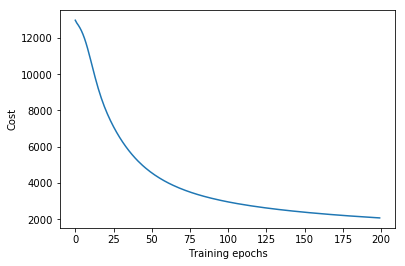

In [33]:
plt.plot(range(nn1.epochs), nn1.eval_["cost"])
plt.ylabel("Cost")
plt.xlabel("Training epochs")
plt.show()

Looking at this, we can see:
- Training rapidly declines between around epochs 10 and 100
- Training converges from around epoch 100 and 200
- The cost doesn't tend that close to asymptotic by epoch 200 - so the cost would likely *continue to decrease* if we were to train the network for more than 200 epochs
- The decrease in the cost is slower for the first 10-or-so training epochs - I don't know why this is!

Let's also take a look at the training and validation accuracy

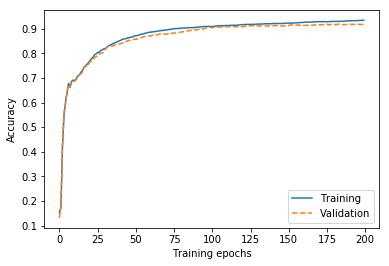

In [34]:
plt.plot(range(nn1.epochs), nn1.eval_["training_accuracy"], label = "Training")
plt.plot(range(nn1.epochs), nn1.eval_["validation_accuracy"], label = "Validation", linestyle = "--")
plt.ylabel("Accuracy")
plt.xlabel("Training epochs")
plt.legend()
plt.show()

Here, we see that the gap between training and validation accuracy increases the more epochs we train the network - after 25-or-so training cycles, the network starts over-fitting (slightly).

Let's have a look at what happens if we try to improve accuracy by 
- incraeasing the number of training cycles (the number of epochs); and
- increasing the regularization strength - i.e. the l2 parameter - to, say, 0.1

In [35]:
# instantiate a neural network object
nn2 = NeuralNetMLP(n_hidden = 25, l2 = 0.1, epochs = 300,
                  learning_rate = 0.0005, minibatch_size = 100,
                  shuffle = True, seed = 1)

In [36]:
# "train" the network on our "training" sub-set of data
nn2.fit(X_train = X_train, y_train = y_train, X_valid = X_test, y_valid = y_test)

300/300 | Cost: 2140.62| Train/Valid accuracy: 93.95%/91.90%%

Hmm. It looks like we have increased the accuracy (a bit) on the training set, but made very little improvement in the validation - so we are still over-fitting the data. Let's plot that and take a closer look

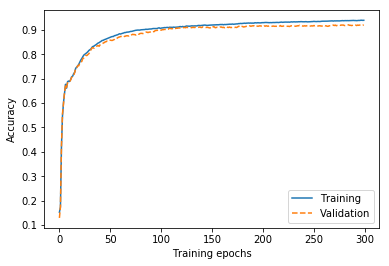

In [37]:
plt.plot(range(nn2.epochs), nn2.eval_["training_accuracy"], label = "Training")
plt.plot(range(nn2.epochs), nn2.eval_["validation_accuracy"], label = "Validation", linestyle = "--")
plt.ylabel("Accuracy")
plt.xlabel("Training epochs")
plt.legend()
plt.show()

Now, let's see what happens when if we increase the number of hidden units in our neural network to 100 (a factor-four increase)

In [38]:
# instantiate a neural network object
nn3 = NeuralNetMLP(n_hidden = 100, l2 = 0.1, epochs = 300,
                  learning_rate = 0.0005, minibatch_size = 100,
                  shuffle = True, seed = 1)

# "fit our training data to the model" (aka, calculate the optimal weights using back-propogation)
nn3.fit(X_train = X_train, y_train = y_train, X_valid = X_test, y_valid = y_test)

300/300 | Cost: 2134.93| Train/Valid accuracy: 93.92%/91.80%%

Not that much difference, to be honest

Finally, let's see what happens if we change the `learning_rate` - let's try a learning rate of 0.01:

In [39]:
# instantiate a neural network object
nn4 = NeuralNetMLP(n_hidden = 100, l2 = 0.1, epochs = 300,
                  learning_rate = 0.01, minibatch_size = 100,
                  shuffle = True, seed = 1)

# "fit our training data to the model" (aka, calculate the optimal weights using back-propogation)
nn4.fit(X_train = X_train, y_train = y_train, X_valid = X_test, y_valid = y_test)

300/300 | Cost: 1403.70| Train/Valid accuracy: 97.02%/94.50%

We achieve an accuracy of around **96%** - which is comparable to the accuracy we achieved with regularized one-vs-all logistic regression (see last week's notes).

With careful calibration of the learning rate and the l2 regularization parameter ($\lambda$), we ought to be able to achieve 100% accuracy on the training data - though this would almost certainly result in over-fitting of the model on the training data (leading to erroneous predictions on previously unseen data).

## 4 Final note on convergence
(*adapted from Raschka & Mirjalili*)

Multi-layer neural networks are *hard* to train. In particular, they have a risk of getting stuck in *local minima*:

![](Figures/convergence.jpg)

(*shows the cost surface for a single weight*)

In fact, it's much *worse* than this diagram suggests - we may well have many hundreds, thousands, millions or even billions (ik, r?!) of weights to train - giving us a cost surface in n-dimensional space that is "rough" - i.e. has very many potential local minima that where our choice of optimization algorithm could end up stuck. And since we start with randomly initialized weights, a local minimum would be a solution that is likely to be very wrong.

Our goal, therefore, is to "miss" or "escape" the local minima, whilst avoiding "over-shooting" the global minimum. To do this we can:

- Use a larger learning rate (i.e. the size of step we take in the opposite direction to the gradient on each pass through the learning); and
- Apply *stochastic* optimization methods (e.g. stochastic gradient descent). These involve segmenting the data (i.e. all the different written letters - represented in our $X$ data) into "batches" and computing the gradients based on this subset. This still allows us to use our vectorized approach, which is computationally efficient, but is also more likely to avoid local minima. We can think of the results as being like using a voter turnout poll to predict the results of an election - we use a representative sample, rather than asking the whole population.